In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import graph_creation
import time
import holidays
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
df = pd.read_excel('GEFCom2014-E.xlsx')
df['dow'] = df.Date.apply(lambda x: x.dayofweek)
df['doy'] = df.Date.apply(lambda x: x.dayofyear)
df['month'] = df.Date.apply(lambda x: x.month)
df = df[df.load.isnull().sum():]
ush = holidays.US()
df['is_holiday'] = 1 * df.Date.apply(lambda x: x in ush)
df = df.reindex(columns=('doy', 'month', 'dow', 'Hour', 'is_holiday', 'T', 'load', 'Date'))
offset = df.load.mean()
scale = df.load.std()
df.load -= df.load.mean()
df.load /= df.load.std()
df['T'] -= df['T'].mean()
df['T'] /= df['T'].std()
del df['Date'], df['doy']


df.month = np.cos(2*np.pi/12*df.month)
df.Hour = np.cos(2*np.pi/24*df.Hour)
df.dow = np.cos(2*np.pi/7*df.dow)

In [5]:
df.head()

,month,dow,Hour,is_holiday,T,load
17544,0.866025,0.62349,0.965926,1,-1.297165,-0.513969
17545,0.866025,0.62349,0.866025,1,-1.401324,-0.784751
17546,0.866025,0.62349,0.707107,1,-1.366604,-0.948599
17547,0.866025,0.62349,0.500000,1,-1.488124,-1.040010
17548,0.866025,0.62349,0.258819,1,-1.470764,-1.033111


In [6]:
train = df[:7*len(df)//8]
# val = df[3*len(df)//4:7*len(df)//8]
test = df[7*len(df)//8:]

In [7]:
nt = np.array(train)
# nv = np.array(val)
ntt = np.array(test)
x_train = nt[:,:-1]
y_train = nt[:,-1]
x_val = ntt[:,:-1]
y_val = ntt[:,-1]

In [8]:
def row2seq_rnn(data, ys, past=24, future=24):
    xl = []
    xfl = []
    yl = []
    for i in range(past, len(data)-future):
        tmp1 = data[i-past:i]
        tmp2 = ys[i-past:i, None]
        xfl.append(data[i:i+future])
        xl.append(np.append(tmp1, tmp2, axis=1))
        yl.append(ys[i:i+future])
    return np.array(xl), np.array(xfl), np.array(yl)
def batch(*vars, size=512):
    for i in range(0, min(len(v) for v in vars), size):
        yield (v[i:i+size] for v in vars)

In [9]:
xt, xtf, yt = row2seq_rnn(x_train, y_train)
xv, xvf, yv = row2seq_rnn(x_val, y_val)
xtt, xttf, ytt = row2seq_rnn(ntt[:,:-1], ntt[:,-1])

In [10]:
hidden_dim = 32

In [11]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, (None, None, xt.shape[2]), name='x_past')
    y = tf.placeholder(tf.float32, (None, None), name='y')
    xf = tf.placeholder(tf.float32, (None, None, xtf.shape[2]), name='x_future')
    keep_prob = tf.placeholder_with_default(1.0, (), name='keep_prob')
    is_training = tf.placeholder_with_default(False, (), name='is_training')
    regularization = tf.placeholder_with_default(0.005, (), name='regularization')
    
    out_weight = tf.Variable(tf.random_normal((hidden_dim,))/hidden_dim, dtype=tf.float32, name='out_weight')
    out_bias = tf.Variable(tf.zeros(1), dtype=tf.float32, name='out_bias')
    
    # Basic seq2seq LSTM
    outputs, _  = graph_creation.s2s_lstm_fixed(x, xf, hidden_dim, 2, use_bn=True, is_training=is_training, keep_prob=keep_prob, project=True)
    
    preds = tf.add(tf.einsum('ijk,k->ij', outputs, out_weight), out_bias, name='predictions')
    loss = tf.reduce_mean((y-preds)**2)
    reg_loss = tf.nn.l2_loss(out_weight) * regularization / tf.cast(tf.shape(x)[0], tf.float32)
    step = tf.train.AdamOptimizer().minimize(loss+reg_loss)
    saver = tf.train.Saver()

hi


In [17]:
try:
    while True:
        tf.get_default_session().close()
except:
    pass
sess = tf.InteractiveSession(graph=g)
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [22]:
def train_epoch(bs, keep_p=1.0):
    perm = np.random.permutation(len(xt))
    errors = []
    for xs, xfs, ys in batch(xt[perm], xtf[perm], yt[perm], size=bs):
        _, l = sess.run((step, loss), feed_dict={x:xs, xf:xfs, y:ys, keep_prob:keep_p, is_training:True})
        errors.append(l)
    return errors
def evaluate(bs):
    l = []
    s = 0
    for xs, xfs, ys in batch(xtt, xttf, ytt, size=bs):
        l.append(sess.run(loss, feed_dict={x:xs, xf:xfs, y:ys})*len(ys))
        s += len(ys)
    return sum(l)/s

In [23]:
bs = 1024

In [24]:
train_errs = []
test_errs = []
for i in range(len(test_errs), 300):
    start = time.time()
    train_err = train_epoch(bs, 0.7)
    train_errs.extend(train_err)
    test_errs.append(evaluate(bs*2))
    end = time.time()
    if i>1 and test_errs[-1]==min(test_errs):
        saver.save(sess, './models/vanilla/model', global_step=len(test_errs))
    print(f'Epoch {i} ({end-start:.2f}s): train_loss={train_errs[-1]:.4f}, test_loss={test_errs[-1]:.4f}')

Epoch 0 (20.19s): train_loss=0.0682, test_loss=0.0432
Epoch 1 (21.72s): train_loss=0.0623, test_loss=0.0431
Epoch 2 (22.41s): train_loss=0.0655, test_loss=0.0392
Epoch 3 (22.14s): train_loss=0.0544, test_loss=0.0340
Epoch 4 (22.45s): train_loss=0.0505, test_loss=0.0338
Epoch 5 (22.56s): train_loss=0.0486, test_loss=0.0315
Epoch 6 (22.00s): train_loss=0.0449, test_loss=0.0294
Epoch 7 (22.25s): train_loss=0.0487, test_loss=0.0350
Epoch 8 (23.08s): train_loss=0.0472, test_loss=0.0312
Epoch 9 (21.91s): train_loss=0.0430, test_loss=0.0291
Epoch 10 (22.00s): train_loss=0.0435, test_loss=0.0297
Epoch 11 (21.84s): train_loss=0.0464, test_loss=0.0296
Epoch 12 (22.24s): train_loss=0.0424, test_loss=0.0305
Epoch 13 (21.72s): train_loss=0.0408, test_loss=0.0277
Epoch 14 (22.88s): train_loss=0.0430, test_loss=0.0270
Epoch 15 (21.48s): train_loss=0.0422, test_loss=0.0304
Epoch 16 (23.55s): train_loss=0.0396, test_loss=0.0260
Epoch 17 (24.07s): train_loss=0.0434, test_loss=0.0268
Epoch 18 (22.90s): t

Epoch 149 (20.48s): train_loss=0.0355, test_loss=0.0177
Epoch 150 (20.56s): train_loss=0.0285, test_loss=0.0187
Epoch 151 (20.59s): train_loss=0.0294, test_loss=0.0177
Epoch 152 (20.40s): train_loss=0.0302, test_loss=0.0187
Epoch 153 (20.56s): train_loss=0.0327, test_loss=0.0181
Epoch 154 (20.50s): train_loss=0.0282, test_loss=0.0182
Epoch 155 (20.38s): train_loss=0.0315, test_loss=0.0188
Epoch 156 (20.69s): train_loss=0.0293, test_loss=0.0177
Epoch 157 (20.35s): train_loss=0.0286, test_loss=0.0175
Epoch 158 (20.28s): train_loss=0.0294, test_loss=0.0199
Epoch 159 (20.86s): train_loss=0.0288, test_loss=0.0190
Epoch 160 (20.21s): train_loss=0.0263, test_loss=0.0196
Epoch 161 (20.51s): train_loss=0.0285, test_loss=0.0167
Epoch 162 (20.80s): train_loss=0.0282, test_loss=0.0172
Epoch 163 (20.52s): train_loss=0.0298, test_loss=0.0174
Epoch 164 (20.43s): train_loss=0.0278, test_loss=0.0178
Epoch 165 (20.66s): train_loss=0.0293, test_loss=0.0176
Epoch 166 (20.28s): train_loss=0.0294, test_loss

Epoch 296 (20.95s): train_loss=0.0250, test_loss=0.0199
Epoch 297 (21.08s): train_loss=0.0269, test_loss=0.0188
Epoch 298 (21.60s): train_loss=0.0286, test_loss=0.0192
Epoch 299 (21.05s): train_loss=0.0272, test_loss=0.0189


In [25]:
def predict(bs):
    l = []
    for xs, xfs, ys in batch(xtt, xttf,  ytt, size=bs):
        l.append(sess.run(preds, feed_dict={x:xs, xf:xfs, y:ys}))
    return np.concatenate(l,0)

In [26]:
pos = predict(bs*2)*scale + offset
yov = ytt*scale + offset
loss_by_horizon = ((yov-pos)**2).mean(0).astype(np.float32)
loss_by_horizon

array([1846.2491, 2841.0579, 3778.1843, 4610.3965, 5355.9927, 5890.725 ,
       6221.749 , 6425.841 , 6514.228 , 6585.705 , 6674.694 , 6760.1655,
       6817.821 , 6884.6504, 6983.393 , 7081.6416, 7150.346 , 7216.728 ,
       7291.4453, 7390.8623, 7552.405 , 7782.729 , 8047.8965, 8381.054 ],
      dtype=float32)

Text(0,0.5,'RMSE')

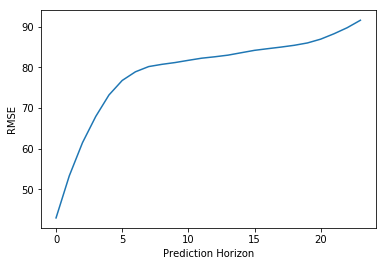

In [28]:
plt.plot(np.sqrt(loss_by_horizon))
plt.xlabel('Prediction Horizon')
plt.ylabel('RMSE')

Text(0,0.5,'MAPE (%)')

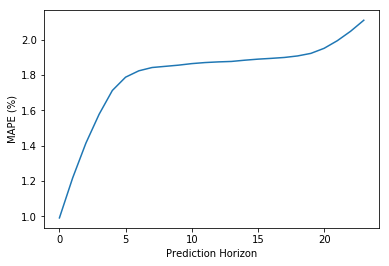

In [32]:
plt.plot((np.abs(yov-pos)/yov).mean(0).astype(np.float32) * 100)
plt.xlabel('Prediction Horizon')
plt.ylabel(r'MAPE (%)')